## Import necessary modules 

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import show
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

## Load .tif files

In [4]:
DATA_DIR = Path('./data')

before = rasterio.open(DATA_DIR / 'sentinel2a-before.tif')
after = rasterio.open(DATA_DIR / 'sentinel2a-after.tif')

assert before.height == after.height
assert before.width == after.width

num_pixels = before.height * before.width
num_pixels

2762460

## Generate some samples

In [5]:
BANDS = [2, 3, 4, 5, 6, 7, 8, 11, 12]
BAND_NAMES = ['B02','B03','B04','B05','B06','B07','B08','B11','B12']
assert len(BANDS) == len(BAND_NAMES)
N_SAMPLES = 20000
N_CLUSTERS = 4

In [6]:
before_arr = before.read(BANDS).astype(np.double)
after_arr = after.read(BANDS).astype(np.double)

# Take care of NaNs
before_2d = before_arr.transpose(1, 2, 0).reshape(-1, len(BANDS))
after_2d = after_arr.transpose(1, 2, 0).reshape(-1, len(BANDS))
imputer = SimpleImputer(strategy='mean')
before_pix_values = imputer.fit_transform(before_2d)
before_arr = before_pix_values.reshape(before.height, before.width, len(BANDS)).transpose(2, 0, 1)
imputer = SimpleImputer(strategy='mean')
after_pix_values = imputer.fit_transform(after_2d)
after_arr = after_pix_values.reshape(after.height, after.width, len(BANDS)).transpose(2, 0, 1)

# Sample some coordinates
np.random.seed(42)
samples_xy = np.random.randint(0, before.height, size=N_SAMPLES)
samples_xy = np.column_stack((samples_xy, np.random.randint(0, before.width, size=N_SAMPLES)))
samples_xy.shape

(20000, 2)

In [7]:
sample_hypercube =  np.zeros((N_SAMPLES, len(BANDS)))

for i, (x, y) in enumerate(samples_xy):
    # Sample from before and after arrays based on index
    if i % 2 == 0:
        sample_hypercube[i]= before_arr[:, x, y]
    else:
        sample_hypercube[i] = after_arr[:, x, y]

sample_hypercube_df = pd.DataFrame(sample_hypercube, columns=BAND_NAMES)
sample_hypercube_df

,B02,B03,B04,B05,B06,B07,B08,B11,B12
0,0.03410,0.03495,0.0238,0.02315,0.02475,0.02540,0.02350,0.01715,0.01535
1,0.04150,0.04345,0.0246,0.02290,0.02295,0.02360,0.02070,0.01295,0.01045
2,0.05015,0.08555,0.0728,0.13435,0.28980,0.31965,0.41355,0.20165,0.13545
3,0.03250,0.04430,0.0354,0.09480,0.22600,0.23330,0.27180,0.16740,0.08960
4,0.04255,0.04975,0.0251,0.02400,0.02500,0.02590,0.02250,0.01725,0.01610
...,...,...,...,...,...,...,...,...,...
19995,0.06810,0.08810,0.1232,0.16120,0.18420,0.20160,0.20980,0.24550,0.16110
19996,0.05305,0.09150,0.0812,0.13840,0.27315,0.30175,0.31950,0.23115,0.15035
19997,0.02350,0.03630,0.0191,0.05670,0.20690,0.27600,0.27350,0.12190,0.04890
19998,0.03470,0.04055,0.0246,0.02490,0.02765,0.02850,0.02520,0.01995,0.01740


## Fit K-means clusterer

In [8]:
KMmodel = KMeans(n_clusters=N_CLUSTERS) 
KMmodel.fit(X=sample_hypercube_df)

KMeans(n_clusters=4)

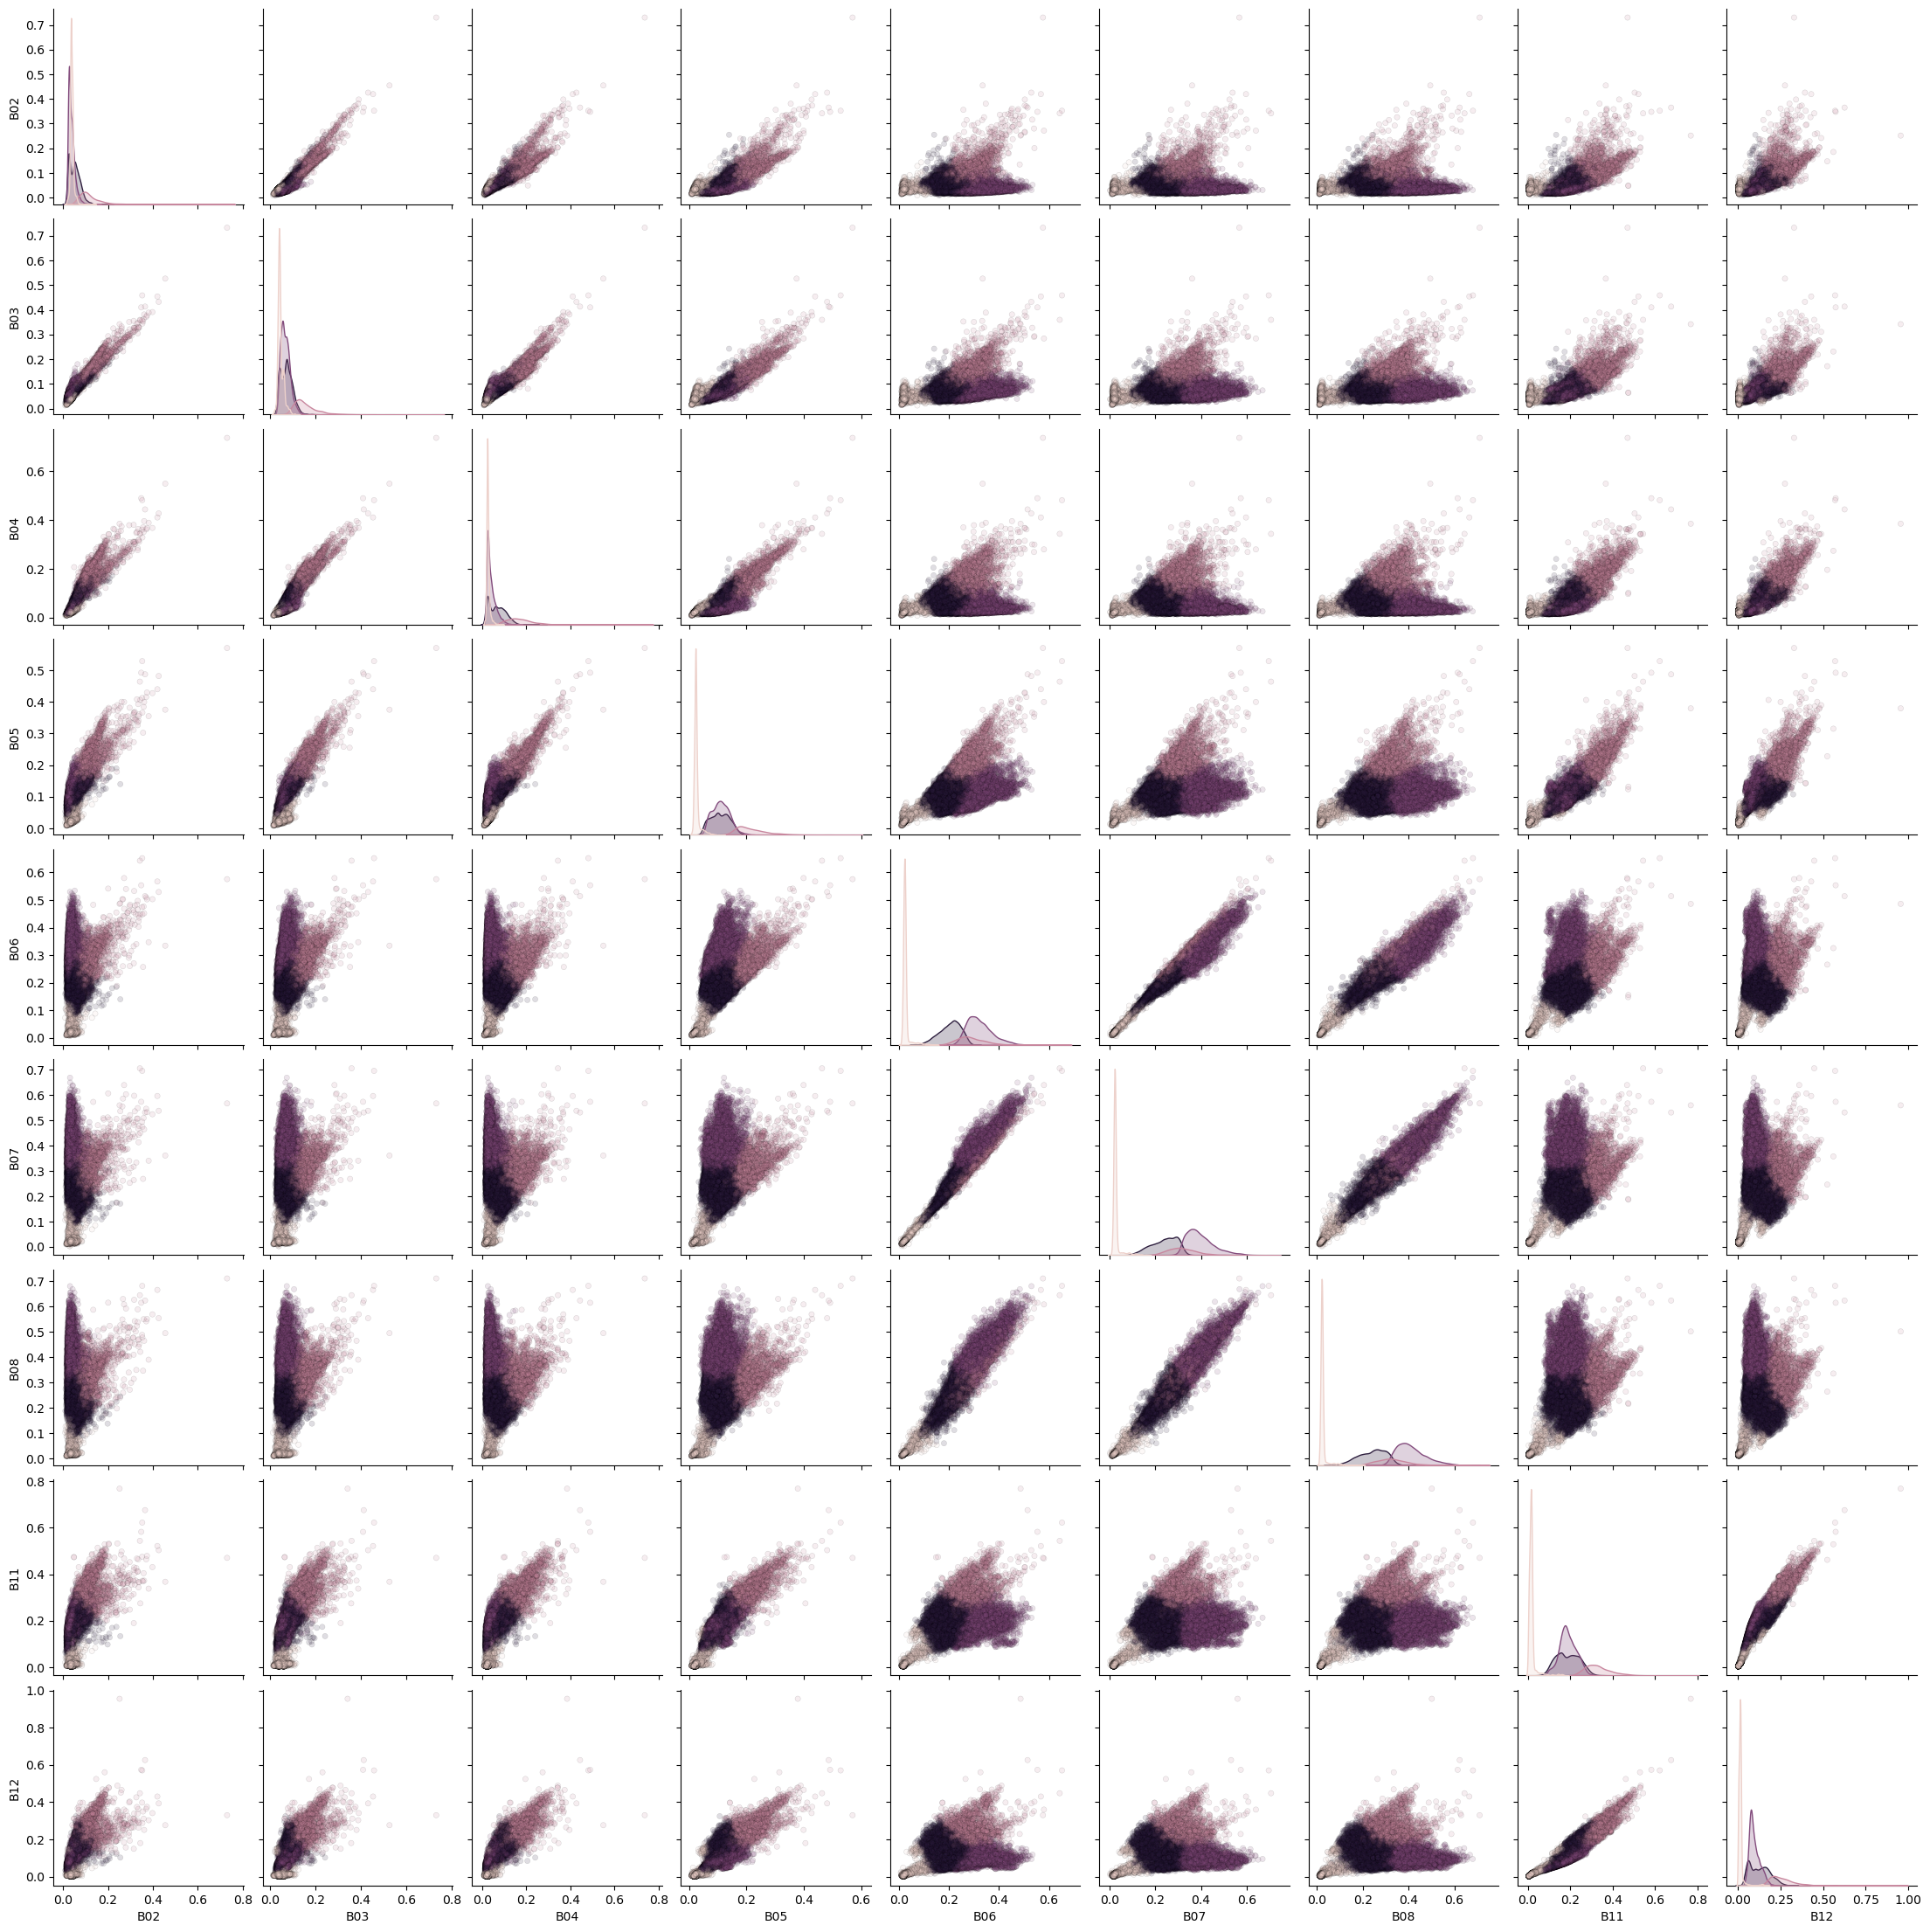

In [9]:
KM_train = list(KMmodel.predict(sample_hypercube_df))
sample_hypercube_df['group'] = KM_train

# Pair plots with clusters coloured (takes some time to depending on (len(BANDS) x len(BANDS)) size)
seaborn_params_p = {'alpha': 0.15, 's': 20, 'edgecolor': 'k'}
pp2 = sns.pairplot(sample_hypercube_df, vars=BAND_NAMES, hue='group', plot_kws=seaborn_params_p)
pp2._legend.remove()

/home/lilian/anaconda3/envs/seeland/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/home/lilian/anaconda3/envs/seeland/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


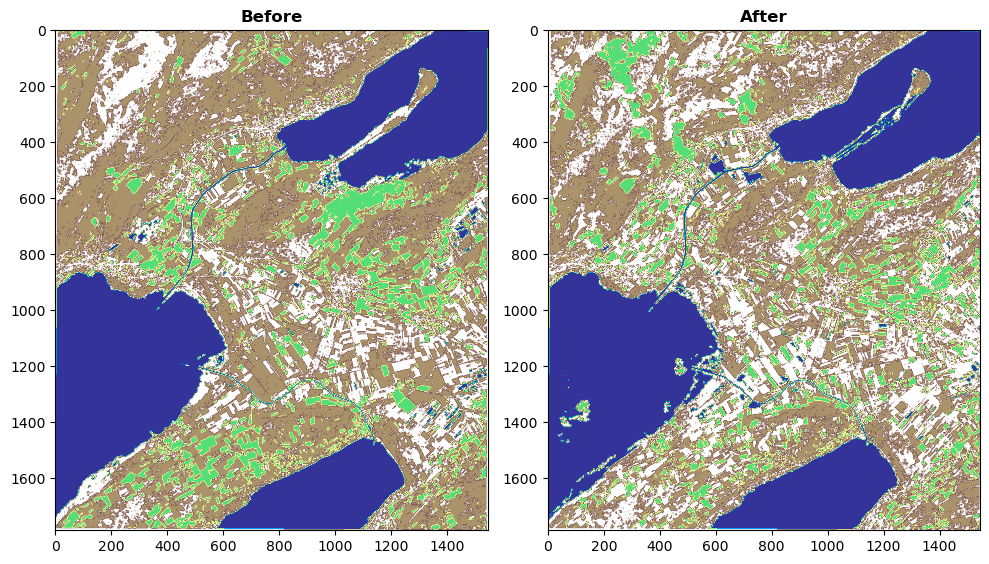

In [10]:
before_clustered = KMmodel.predict(before_arr.reshape(before_arr.shape[0], -1).T)
before_clustered = before_clustered.reshape(before.height, before.width)

after_clustered = KMmodel.predict(after_arr.reshape(after_arr.shape[0], -1).T)
after_clustered = after_clustered.reshape(after.height, after.width)

fig, axs = plt.subplots(1, 2, figsize=(10,10))
show(before_clustered, ax=axs[0], cmap='terrain', title='Before')
show(after_clustered, ax=axs[1], cmap='terrain', title='After')
plt.tight_layout()
plt.show()

## Analyze cluster positions to spot the water centroid

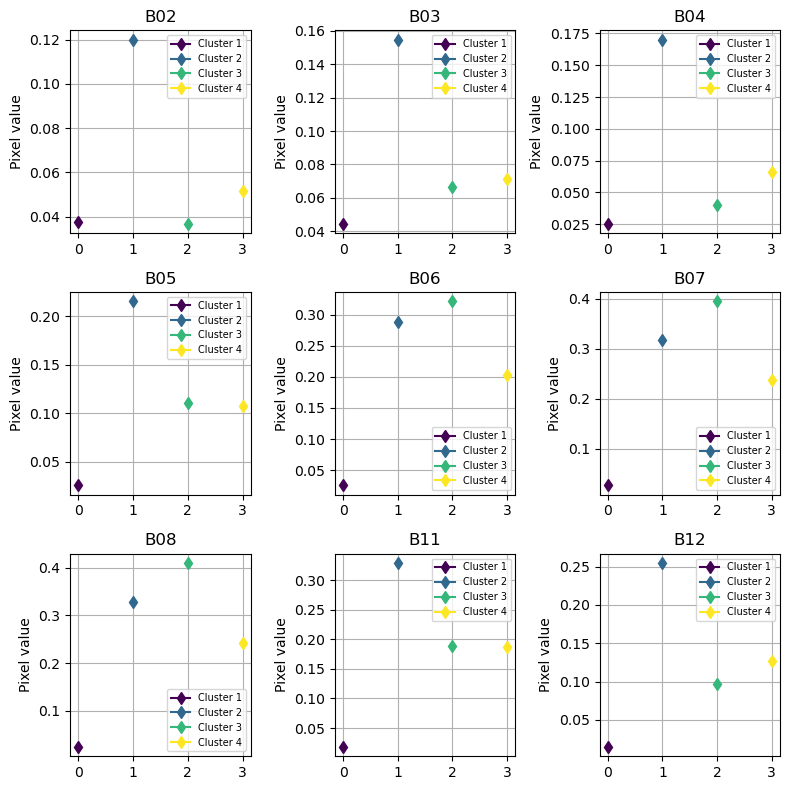

In [11]:
colors = plt.cm.viridis(np.linspace(0, 1, N_CLUSTERS))

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axs.flat):
    for j in range(N_CLUSTERS):
        ax.plot(j, KMmodel.cluster_centers_[j, i], marker='d', color=colors[j], label='Cluster {}'.format(j+1))
    ax.set_title(BAND_NAMES[i])
    ax.set_ylabel('Pixel value')
    ax.grid(True)
    ax.legend(fontsize=7)

plt.tight_layout()
plt.show()